In [1]:
# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Keras / TensorFlow - Layers & Models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

# Keras / TensorFlow - Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2025-06-25 10:57:13.169808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/antotim/Desktop/POWER_AI/data/merged_dataset.csv')
df.drop(columns=['id'], inplace=True)

# Data Split

In [3]:
df_pdu = df[[col for col in df.columns if col.startswith('pdu')] + ['data_hora']].copy()
df_pdu.columns

Index(['pdu1_i', 'pdu1_fp', 'pdu1_kwh', 'pdu2_i', 'pdu2_fp', 'pdu2_kwh',
       'pdu3_i', 'pdu3_fp', 'pdu3_kwh', 'pdu4_i', 'pdu4_fp', 'pdu4_kwh',
       'pdu5_i', 'pdu5_fp', 'pdu5_kwh', 'pdu6_i', 'pdu6_fp', 'pdu6_kwh',
       'pdu7_i', 'pdu7_fp', 'pdu7_kwh', 'pdu8_i', 'pdu8_fp', 'pdu8_kwh',
       'data_hora'],
      dtype='object')

In [4]:
def window_dataframe_pdu(df, window_size=12):
    """
    Transform PDU DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index (e.g., pdu1_i-1, pdu1_i-2, ...).
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")

    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)

# PDU_I

In [5]:
df_pdu_i = df_pdu[['pdu1_i', 'pdu2_i', 'pdu3_i', 'pdu4_i', 'pdu5_i', 'pdu6_i', 'pdu7_i', 'pdu8_i']].copy()

### 1. Data Preparation

In [6]:
# Parameters
window_size = 16
pdu_i_phases = ['pdu1_i', 'pdu2_i', 'pdu3_i', 'pdu4_i', 'pdu5_i', 'pdu6_i', 'pdu7_i', 'pdu8_i']

# Windowing
df_pdu_i_win = window_dataframe_pdu(df_pdu_i, window_size=window_size)
df_pdu_i_win_plot = df_pdu_i_win.copy()

In [7]:
df_pdu_i_win.head()

,pdu1_i-1,pdu1_i-2,pdu1_i-3,pdu1_i-4,pdu1_i-5,pdu1_i-6,pdu1_i-7,pdu1_i-8,pdu1_i-9,pdu1_i-10,...,pdu8_i-7,pdu8_i-8,pdu8_i-9,pdu8_i-10,pdu8_i-11,pdu8_i-12,pdu8_i-13,pdu8_i-14,pdu8_i-15,pdu8_i-16
0,1.69,1.69,1.69,1.69,1.69,1.70,1.70,1.69,1.69,1.69,...,4.44,4.44,4.57,4.59,4.46,4.43,4.50,4.43,4.44,4.44
1,1.70,1.69,1.70,1.69,1.69,1.69,1.70,1.69,1.69,1.69,...,4.44,4.43,4.50,4.50,4.45,4.43,4.44,4.42,4.44,4.45
2,1.69,1.69,1.69,1.69,1.69,1.70,1.70,1.70,1.69,1.69,...,4.44,4.44,4.44,4.43,4.50,4.43,4.44,4.43,4.43,4.44
3,1.69,1.69,1.70,1.69,1.69,1.69,1.69,1.69,1.69,1.69,...,4.44,4.44,4.43,4.44,4.43,4.46,4.60,4.55,4.44,4.44
4,1.69,1.69,1.69,1.70,1.69,1.69,1.69,1.69,1.69,1.69,...,4.44,4.44,4.59,4.57,4.45,4.43,4.54,4.43,4.46,4.44


### Compute Windows Means

In [8]:
pdu_phases = ['pdu1_i', 'pdu2_i', 'pdu3_i', 'pdu4_i', 'pdu5_i', 'pdu6_i', 'pdu7_i', 'pdu8_i']

for phase in pdu_phases:
    cols = [f"{phase}-{i+1}" for i in range(window_size)]
    df_pdu_i_win_plot[f"{phase}_mean"] = df_pdu_i_win_plot[cols].mean(axis=1)

### Assign Timestamps

In [9]:
# Ensure df_pdu is sorted by time
df_pdu['data_hora'] = pd.to_datetime(df_pdu['data_hora'])
df_pdu = df_pdu.sort_values('data_hora')

# Assign timestamps to each window (last timestamp in each window)
timestamps = df_pdu['data_hora'].values
n_windows = len(df_pdu_i_win_plot)
window_timestamps = [timestamps[(i+1)*window_size - 1] for i in range(n_windows)]
df_pdu_i_win_plot['window_time'] = pd.to_datetime(window_timestamps)
df_pdu_i_win_plot = df_pdu_i_win_plot.set_index('window_time')

### Plot Windowed Means

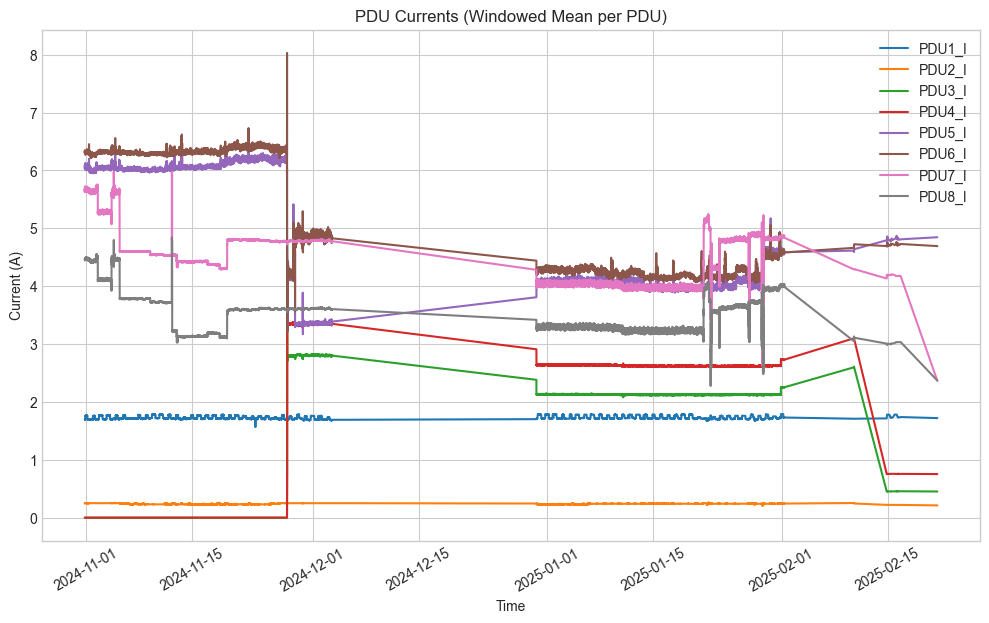

In [10]:
# Plot windowed means for PDU currents
plt.figure(figsize=(10, 6))
for phase in pdu_phases:
    plt.plot(df_pdu_i_win_plot.index, df_pdu_i_win_plot[f"{phase}_mean"], label=phase.upper())

plt.title("PDU Currents (Windowed Mean per PDU)")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

### 2.Autoencoder

#### Data Split

In [11]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

# Define test period
test_start = pd.to_datetime('2024-12-29')
test_end = pd.to_datetime('2025-02-23')

In [12]:
# Split windowed data
test_mask = (df_pdu_i_win_plot.index >= test_start) & (df_pdu_i_win_plot.index <= test_end)
df_test_win = df_pdu_i_win_plot[test_mask].copy()
df_train_win = df_pdu_i_win_plot[~test_mask].copy()

# Drop mean columns for model input
X_train_win = df_train_win.drop(columns=[c for c in df_train_win.columns if c.endswith('_mean')])
X_test_win = df_test_win.drop(columns=[c for c in df_test_win.columns if c.endswith('_mean')])

#### Scaling

In [13]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_win)
X_test_scaled = scaler.transform(X_test_win)

#### Model Def & Training

In [14]:
# Build autoencoder
model_ae = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(1e-4)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train_scaled.shape[1], activation='linear')
])
model_ae.compile(optimizer='adam', loss='mse')

/Users/antotim/.pyenv/versions/power_ai_clean/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
early_stop_ae = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_ae = ModelCheckpoint("models/best_model_ae_pdu_i.h5", monitor='val_loss', save_best_only=True)

history_ae = model_ae.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,  # pareil ici
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_ae, checkpoint_ae],
    verbose=1,
    shuffle=True
)


Epoch 1/50
415/428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2244

428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2200 - val_loss: 2.7266
Epoch 2/50
408/428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 2.6967
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 2.7154
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 2.7127
Epoch 5/50
420/428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 2.6371
Epoch 6/50
404/428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 2.6049
Epoch 7/50
418/428 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 2.5920
Epoch 8/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 2.6025
Epoch 9/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 2.6331
Epoch 10/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0134 - val_loss: 2.6542
Epoch 11/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 2.6713
Epoch 12/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 2.7659
Epoch 13/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 2.7230
Epoch 14/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 2.7454


#### Anomaly Detection

In [16]:
# Predict and detect anomalies
reconstructed = model_ae.predict(X_test_scaled)
reconstruction_errors = np.mean(np.square(X_test_scaled - reconstructed), axis=1)
threshold = np.percentile(reconstruction_errors, 99.75)
anomalies = reconstruction_errors > threshold

df_test_win['reconstruction_error_ae'] = reconstruction_errors
df_test_win['predicted_label_ae'] = anomalies.astype(int)

519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


#### Plot Results

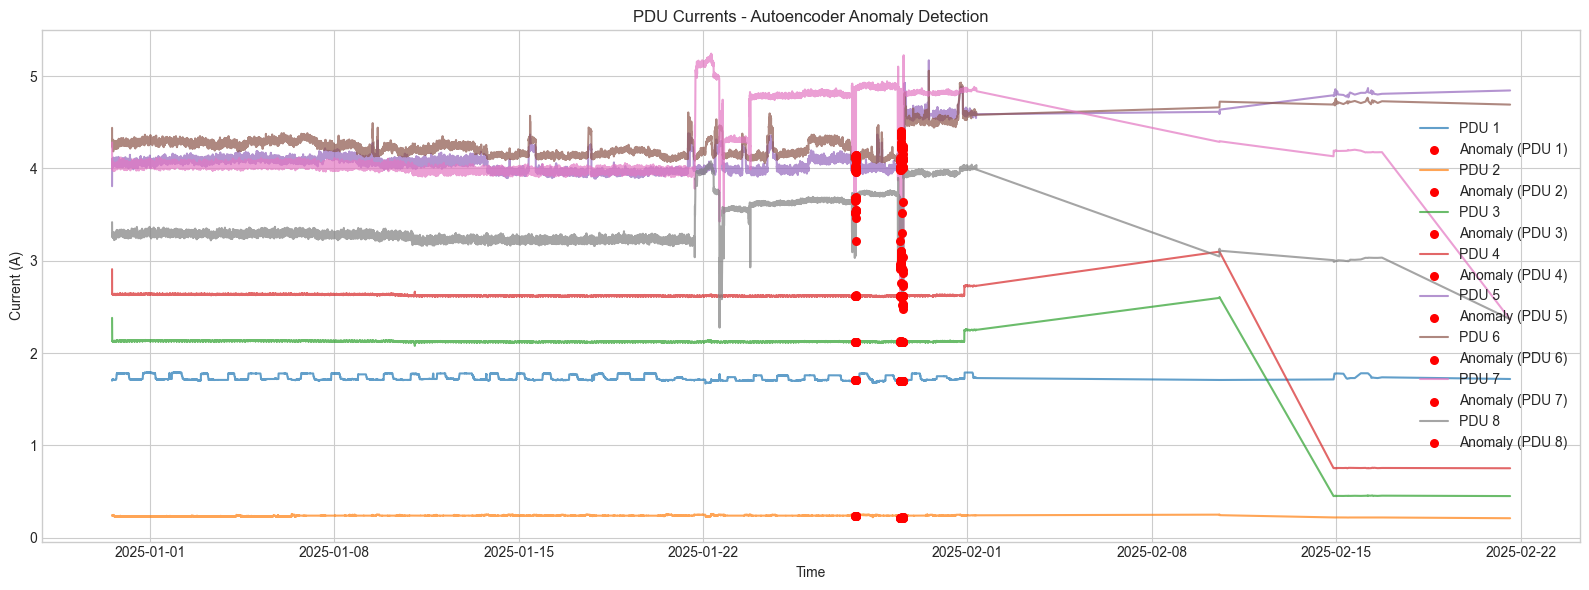

In [17]:
# PDU labels (can be renamed as needed)
pdu_labels = [f"PDU {i}" for i in range(1, 9)]

plt.figure(figsize=(16, 6))
for phase, label in zip(pdu_phases, pdu_labels):
    plt.plot(df_test_win.index, df_test_win[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_win.index[df_test_win['predicted_label_ae'] == 1],
        df_test_win.loc[df_test_win['predicted_label_ae'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f'Anomaly ({label})'
    )

plt.title("PDU Currents - Autoencoder Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.LSTM

#### Scaling & Reshaping

In [18]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Scale (LSTM prefers MinMaxScaler)
scaler_lstm = MinMaxScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train_win)
X_test_scaled_lstm = scaler_lstm.transform(X_test_win)

In [19]:
# Reshape for LSTM
n_features = 8 
sequence_length = window_size
X_train_seq = X_train_scaled_lstm.reshape(-1, sequence_length, n_features)
X_test_seq = X_test_scaled_lstm.reshape(-1, sequence_length, n_features)

#### Model Def & Training

In [20]:
# Build LSTM autoencoder
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, n_features), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
model_lstm.compile(optimizer='adam', loss='mse')

/Users/antotim/.pyenv/versions/power_ai_clean/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("models/best_model_lstm_pdu_i.h5", monitor='val_loss', save_best_only=True)

history_lstm = model_lstm.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1011

481/481 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1009 - val_loss: 0.0071
Epoch 2/50
479/481 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065

481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 3/50
479/481 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021

481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0015 - val_loss: 9.6348e-04
Epoch 5/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0012 - val_loss: 6.3250e-04
Epoch 6/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/50
479/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0011 - val_loss: 5.9367e-04
Epoch 8/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7002e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 9.7009e-04 - val_loss: 4.3077e-04
Epoch 9/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 9.3303e-04 - val_loss: 4.6092e-04
Epoch 10/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 9.1150e-04 - val_loss: 0.0011
Epoch 11/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 8.8722e-04 - val_loss: 5.3367e-04
Epoch 12/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.9930e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 8.9921e-04 - val_loss: 3.5255e-04
Epoch 13/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 8.6337e-04 - val_loss: 4.5395e-04
Epoch 14/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 8.6301e-04 - val_loss: 3.6353e-04
Epoch 15/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 8.1510e-04 - val_loss: 6.6744e-04
Epoch 16/50
478/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1824e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 8.1839e-04 - val_loss: 3.0904e-04
Epoch 17/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 8.0385e-04 - val_loss: 3.4503e-04
Epoch 18/50
478/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0344e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 8.0337e-04 - val_loss: 3.0522e-04
Epoch 19/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.9278e-04 - val_loss: 3.5320e-04
Epoch 20/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.9681e-04 - val_loss: 3.8402e-04
Epoch 21/50
477/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.8981e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.8980e-04 - val_loss: 2.6169e-04
Epoch 22/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.7979e-04 - val_loss: 3.0660e-04
Epoch 23/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.5424e-04 - val_loss: 5.1167e-04
Epoch 24/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.6725e-04 - val_loss: 2.8616e-04
Epoch 25/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4329e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.4331e-04 - val_loss: 2.5914e-04
Epoch 26/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.4406e-04 - val_loss: 2.9112e-04
Epoch 27/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.7795e-04 - val_loss: 4.0500e-04
Epoch 28/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.4191e-04 - val_loss: 3.8645e-04
Epoch 29/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.4179e-04 - val_loss: 3.3307e-04
Epoch 30/50
478/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3214e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.3217e-04 - val_loss: 2.5719e-04
Epoch 31/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.1357e-04 - val_loss: 3.3021e-04
Epoch 32/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.1341e-04 - val_loss: 0.0010
Epoch 33/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.4848e-04 - val_loss: 3.0437e-04
Epoch 34/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.1074e-04 - val_loss: 2.7935e-04
Epoch 35/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 7.1782e-04 - val_loss: 2.9549e-04
Epoch 36/50
479/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.0384e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.0376e-04 - val_loss: 2.3835e-04
Epoch 37/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.7619e-04 - val_loss: 3.3052e-04
Epoch 38/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.9026e-04 - val_loss: 2.4455e-04
Epoch 39/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7192e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.7194e-04 - val_loss: 2.2139e-04
Epoch 40/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.7566e-04 - val_loss: 2.2502e-04
Epoch 41/50
479/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6648e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.6661e-04 - val_loss: 2.0467e-04
Epoch 42/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.4613e-04 - val_loss: 2.1587e-04
Epoch 43/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.4675e-04 - val_loss: 2.3230e-04
Epoch 44/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.4394e-04 - val_loss: 0.0010
Epoch 45/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.7319e-04 - val_loss: 2.5911e-04
Epoch 46/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.4515e-04 - val_loss: 2.3217e-04
Epoch 47/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1639e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.1641e-04 - val_loss: 1.8041e-04
Epoch 48/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2490e-04

481/481 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.2490e-04 - val_loss: 1.4853e-04
Epoch 49/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.9519e-04 - val_loss: 2.2038e-04
Epoch 50/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 5.9459e-04 - val_loss: 1.9701e-04


#### Anomaly Detection

In [22]:
# Predict and detect anomalies
X_test_pred = model_lstm.predict(X_test_seq)
reconstruction_error_lstm = np.mean(np.square(X_test_pred - X_test_seq), axis=(1, 2))
threshold_lstm = np.percentile(reconstruction_error_lstm, 99.75)
anomalies_lstm = reconstruction_error_lstm > threshold_lstm

df_test_win['reconstruction_error_lstm'] = reconstruction_error_lstm
df_test_win['predicted_label_lstm'] = anomalies_lstm.astype(int)

519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


#### Plot Results

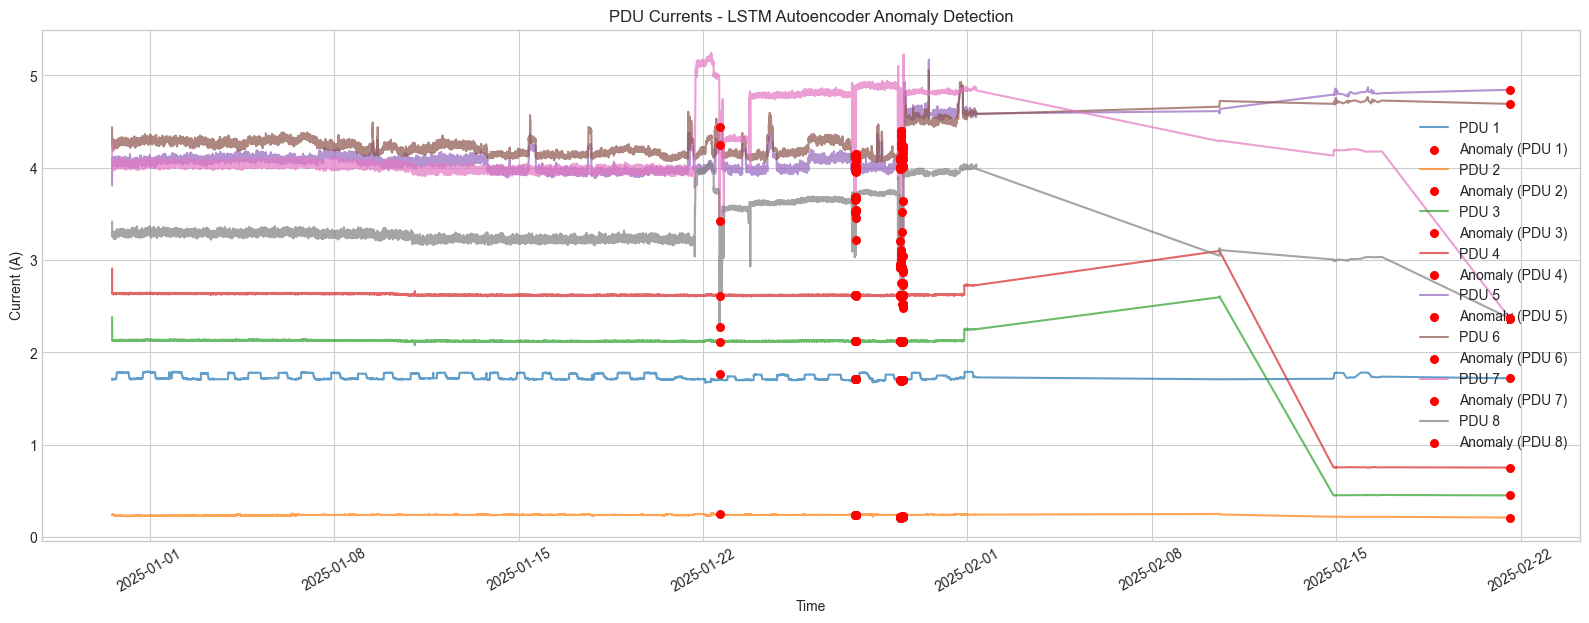

In [23]:
plt.figure(figsize=(16, 6))
for phase, label in zip(pdu_phases, pdu_labels):
    plt.plot(df_test_win.index, df_test_win[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_win.index[df_test_win['predicted_label_lstm'] == 1],
        df_test_win.loc[df_test_win['predicted_label_lstm'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f'Anomaly ({label})'
    )

plt.title("PDU Currents - LSTM Autoencoder Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

#### Comparing with supervisor's anomalies

In [24]:
# Supervisor's anomaly intervals (replace with actual intervals)
supervisor_anomalies = [
    (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 10:33'), pd.Timestamp('2025-01-04 10:35')),
    (pd.Timestamp('2025-02-10 13:39'), pd.Timestamp('2025-02-10 13:41')),
    (pd.Timestamp('2025-02-14 19:21'), pd.Timestamp('2025-02-14 19:23')),
    (pd.Timestamp('2025-02-14 21:30'), pd.Timestamp('2025-02-14 21:33'))
]

def is_true_positive(ts, intervals, tolerance=pd.Timedelta('2min')):
    return any(start - tolerance <= ts <= end + tolerance for start, end in intervals)

def compare_anomalies(detected_indices, intervals, tolerance=pd.Timedelta('2min')):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals, tolerance)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals, tolerance)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval], tolerance) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

# Autoencoder
detected_ae = df_test_win.index[df_test_win['predicted_label_ae'] == 1]
tp_ae, fp_ae, fn_ae = compare_anomalies(detected_ae, supervisor_anomalies, tolerance=pd.Timedelta('2min'))

# LSTM
detected_lstm = df_test_win.index[df_test_win['predicted_label_lstm'] == 1]
tp_lstm, fp_lstm, fn_lstm = compare_anomalies(detected_lstm, supervisor_anomalies)

print("Autoencoder:")
print(f"  Total detected: {len(detected_ae)}")
print(f"  True positives: {len(tp_ae)}")
print(f"  False positives: {len(fp_ae)}")
print(f"  False negatives: {len(fn_ae)}")

print("LSTM:")
print(f"  Total detected: {len(detected_lstm)}")
print(f"  True positives: {len(tp_lstm)}")
print(f"  False positives: {len(fp_lstm)}")
print(f"  False negatives: {len(fn_lstm)}")

Autoencoder:
  Total detected: 42
  True positives: 0
  False positives: 42
  False negatives: 5
LSTM:
  Total detected: 42
  True positives: 0
  False positives: 42
  False negatives: 5


#### Summary Table

In [25]:
summary = pd.DataFrame({
    "Model": ["Autoencoder", "LSTM"],
    "Window Size": [window_size, window_size],
    "Total Detected": [len(detected_ae), len(detected_lstm)],
    "True Positives": [len(tp_ae), len(tp_lstm)],
    "False Positives": [len(fp_ae), len(fp_lstm)],
    "False Negatives": [len(fn_ae), len(fn_lstm)],
})

In [26]:
summary 

,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,16,42,0,42,5
1,LSTM,16,42,0,42,5


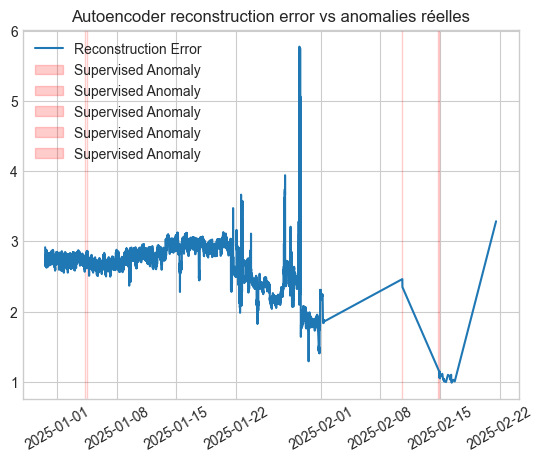

In [27]:
plt.plot(df_test_win.index, df_test_win['reconstruction_error_ae'], label="Reconstruction Error")
for start, end in supervisor_anomalies:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Supervised Anomaly')
plt.legend()
plt.title("Autoencoder reconstruction error vs anomalies réelles")
plt.xticks(rotation=30)
plt.show()